In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import *
import numpy as np
import seaborn as sns
import warnings
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from bayes_opt import BayesianOptimization
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.extmath import softmax
warnings.filterwarnings("ignore")

In [2]:
random.seed(0)
random.randint(2009,2021)

2015

In [3]:
# Read CSV files
yellow_15_list = []
temp_15_list = []
for month in range(1, 13):
    yellow_15_list.append(pd.read_csv(f'yellow_tripdata_2015-{month:02}.csv'))
    temp_15_list.append(pd.read_csv(f'2015-{month:02}.csv'))

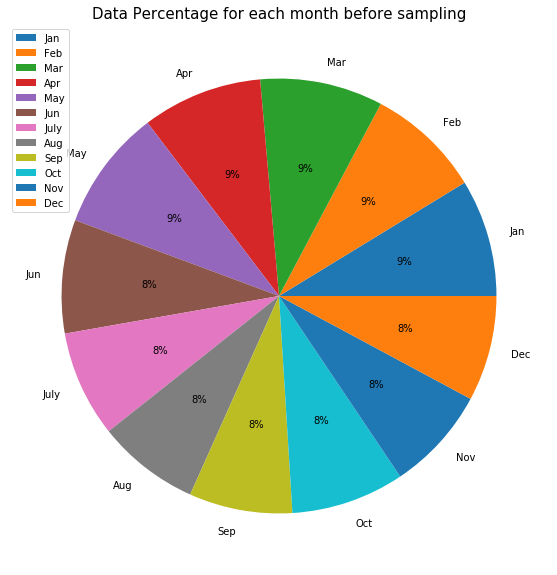

In [4]:
month_count = []
for month in range(12):
    month_count.append(yellow_15_list[month].shape[0])

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(figsize = (10,10))
ax.pie(month_count, labels = labels, autopct='%1.f%%')
ax.set_title(f'Data Percentage for each month before sampling', fontsize = 15)
plt.legend(labels = labels, loc="best")
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig("1.Data Percentage for each month before sampling.jpg")
plt.close()

In [5]:
# lower cases
for month in range(12):
    yellow_15_list[month] = yellow_15_list[month].rename(str.lower, axis = 'columns')
    # drop non-credict records
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].payment_type != 1].index)  
    yellow_15_list[month] = yellow_15_list[month].sample(int(0.01*yellow_15_list[month].shape[0]), random_state = 42)
     
    # Convert daytime
    yellow_15_list[month]['tpep_pickup_datetime'] =  pd.to_datetime(yellow_15_list[month]['tpep_pickup_datetime'])
    yellow_15_list[month]['tpep_dropoff_datetime'] =  pd.to_datetime(yellow_15_list[month]['tpep_dropoff_datetime'])
    
    # Calculate month (1-12)
    yellow_15_list[month]['month'] = yellow_15_list[month]['tpep_pickup_datetime'].dt.month
    # Day of month
    yellow_15_list[month]['date'] = yellow_15_list[month]['tpep_pickup_datetime'].dt.day
    yellow_15_list[month] = pd.merge(yellow_15_list[month], temp_15_list[month], left_on = "date", right_on="Time").drop('Time', axis=1)

yellow_15_list = pd.concat(yellow_15_list)

In [6]:
yellow_15_list.to_csv('Sampled data')

In [7]:
yellow_15_list = pd.read_csv("Sampled data")
yellow_15_list['tpep_pickup_datetime'] =  pd.to_datetime(yellow_15_list['tpep_pickup_datetime'])
yellow_15_list['tpep_dropoff_datetime'] =  pd.to_datetime(yellow_15_list['tpep_dropoff_datetime'])

In [8]:
# Calculate month (1-12)
yellow_15_list['month'] = yellow_15_list['tpep_pickup_datetime'].dt.month

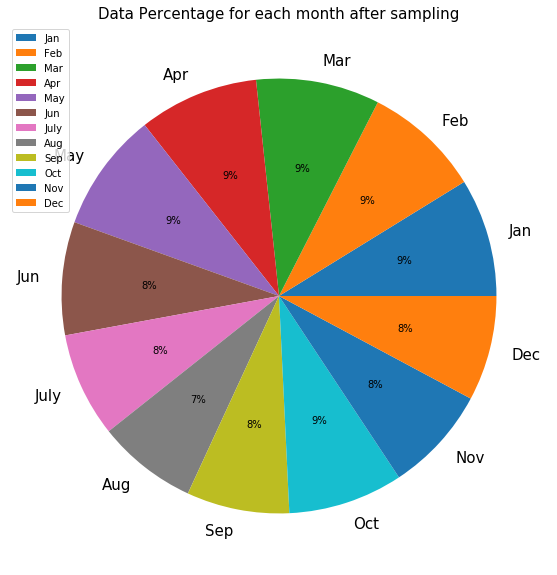

In [9]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(figsize = (10,10))
ax.pie(yellow_15_list.groupby('month').size(), labels = labels, autopct='%1.f%%')
ax.set_title(f'Data Percentage for each month after sampling', fontsize = 15)
plt.legend(labels = labels, loc="best")
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig("2.Data Percentage for each month after sampling.jpg")
plt.close()

# Preprocessing

In [10]:
# Test for NAN
nan_rows = yellow_15_list[yellow_15_list.isnull().any(axis=1)].shape[0]
total_rows = yellow_15_list.shape[0]
    
print(f'The inital amount data of 2015 is {total_rows}.')
print(f'The missing data of 2015 is {nan_rows}.')

The inital amount data of 2015 is 917592.
The missing data of 2015 is 0.


In [11]:
# Calculate trip duration
timediff = yellow_15_list.tpep_dropoff_datetime-yellow_15_list.tpep_pickup_datetime
yellow_15_list['duration'] = timediff / np.timedelta64(1, 'm')
# Calculate speed
yellow_15_list['speed'] = yellow_15_list['trip_distance'] / (yellow_15_list['duration'] / 60)
# Calculate day (MON-SUN)
yellow_15_list['dayofweek'] = yellow_15_list['tpep_pickup_datetime'].dt.dayofweek + 1
# Calculate time (0-23)
yellow_15_list['time'] = yellow_15_list['tpep_pickup_datetime'].dt.hour

In [12]:
# Calculate money per mile
yellow_15_list['price_per_mile'] = yellow_15_list['fare_amount'] / (yellow_15_list['trip_distance'])
yellow_15_list['price_per_min'] = yellow_15_list['fare_amount'] / (yellow_15_list['duration'])
yellow_15_list['except_tip'] = yellow_15_list['total_amount'] - yellow_15_list['tip_amount']

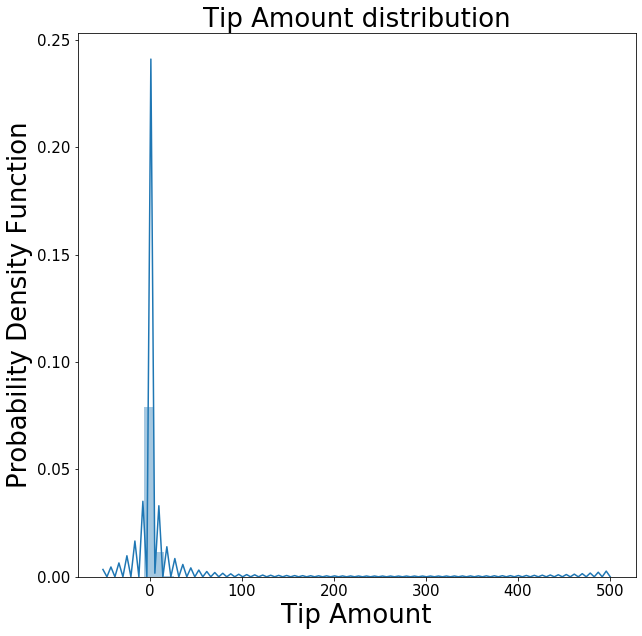

In [13]:
# tip amount distribition
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list['tip_amount'], bins = 50)

ax.set_title(f'Tip Amount distribution', fontsize = 26)
ax.set_xlabel('Tip Amount', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('3.Tip Amount Distribution.jpg')
plt.close()

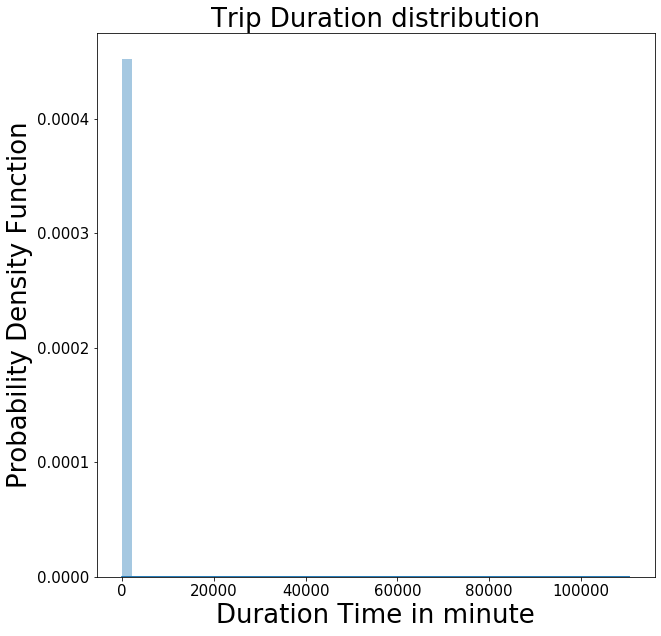

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list['duration'], bins = 50)

ax.set_title(f'Trip Duration distribution', fontsize = 26)
ax.set_xlabel('Duration Time in minute', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('4.Trip Duration Distribution.jpg')
plt.close()

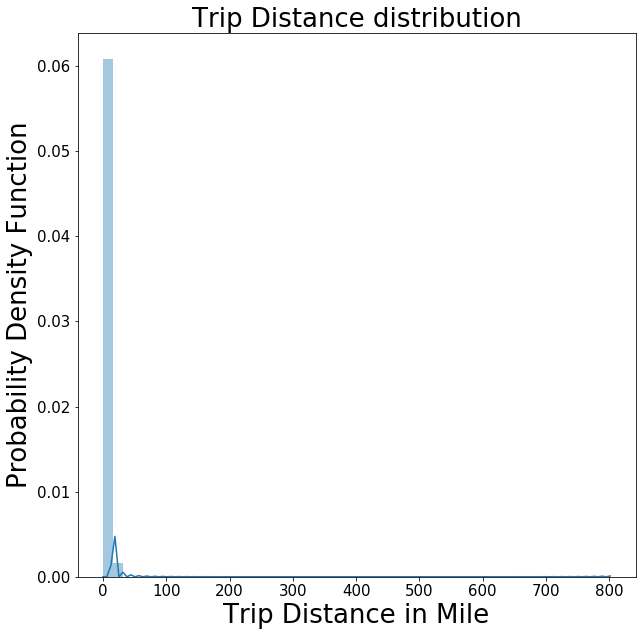

In [15]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list['trip_distance'], bins = 50)

ax.set_title(f'Trip Distance distribution', fontsize = 26)
ax.set_xlabel('Trip Distance in Mile', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('5.Trip Distance Distribution.jpg')
plt.close()

In [16]:
# Remove simple outliers
# Remove passenger_count outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.passenger_count <= 0].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.passenger_count > 6].index)
    
# Remove trip_distance outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.trip_distance <= 0].index)
    
# Remove RateCodeID outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.ratecodeid > 6].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.ratecodeid < 0].index)
    
# Remove extra outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.extra < 0].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.extra > 1.5].index)
    
# Remove MTA_tax outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[(yellow_15_list.mta_tax != 0) & (yellow_15_list.mta_tax != 0.5)].index)
    
# Remove improvement_surcharge outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[(yellow_15_list.improvement_surcharge != 0) & (yellow_15_list.improvement_surcharge != 0.3)].index)

# Remove total_amount outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.total_amount < 0].index)

In [17]:
# Remove outliers

# Remove pickup latitude outliers
longitude_range = [-74.257159, -73.699215]
latitude_range = [40.495992, 40.915568]
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.pickup_latitude < latitude_range[0]].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.pickup_latitude > latitude_range[1]].index)
# Remove dropoff latitude outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.dropoff_latitude < latitude_range[0]].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.dropoff_latitude > latitude_range[1]].index)
# Remove pickup longitude outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.pickup_longitude < longitude_range[0]].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.pickup_longitude > longitude_range[1]].index)
# Remove dropoff longitude outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.dropoff_longitude < longitude_range[0]].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.dropoff_longitude > longitude_range[1]].index)

# Remove speed outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.speed > 65].index)
    
# Remove duration outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.duration <= 0].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.duration > 180].index)
    
# Remove price_per_mile, price_per_min outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[(yellow_15_list.price_per_mile / 5) <= 0].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[((yellow_15_list.price_per_mile / 5) > 3) | ((yellow_15_list.price_per_min / 5) > 3)].index)
    
# Remove tip outliers
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.tip_amount < 0].index)
q1 = yellow_15_list['tip_amount'].quantile(0.25)
q3 = yellow_15_list['tip_amount'].quantile(0.75)
IQR = q3 - q1
yellow_15_list = yellow_15_list.drop(yellow_15_list[(yellow_15_list.tip_amount > q3 + 3*IQR) | (yellow_15_list.tip_amount < q1 - 3*IQR)].index)
yellow_15_list = yellow_15_list.drop(yellow_15_list[yellow_15_list.tip_amount > 0.3 * yellow_15_list.except_tip].index)

In [18]:
# Test for NAN
nan_rows = yellow_15_list[yellow_15_list.isnull().any(axis=1)].shape[0]
total_rows = yellow_15_list.shape[0]
    
print(f'The remaining amount data of 2015 is {total_rows}.')
print(f'The remaining missing data of 2015 is {nan_rows}.')

The remaining amount data of 2015 is 838028.
The remaining missing data of 2015 is 0.


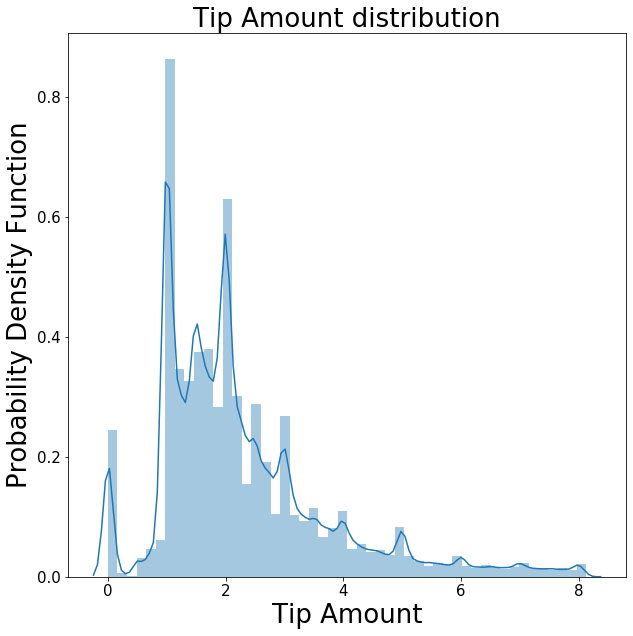

In [19]:
# tip amount distribition
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list['tip_amount'], bins = 50)

ax.set_title(f'Tip Amount distribution', fontsize = 26)
ax.set_xlabel('Tip Amount', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('6.Tip Amount Distribution.jpg')
plt.close()

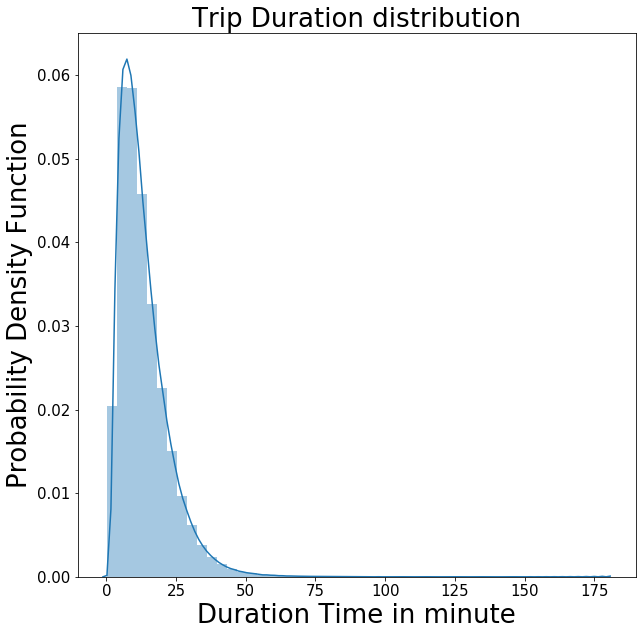

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list['duration'], bins = 50)

ax.set_title(f'Trip Duration distribution', fontsize = 26)
ax.set_xlabel('Duration Time in minute', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('7.Trip Duration Distribution.jpg')
plt.close()

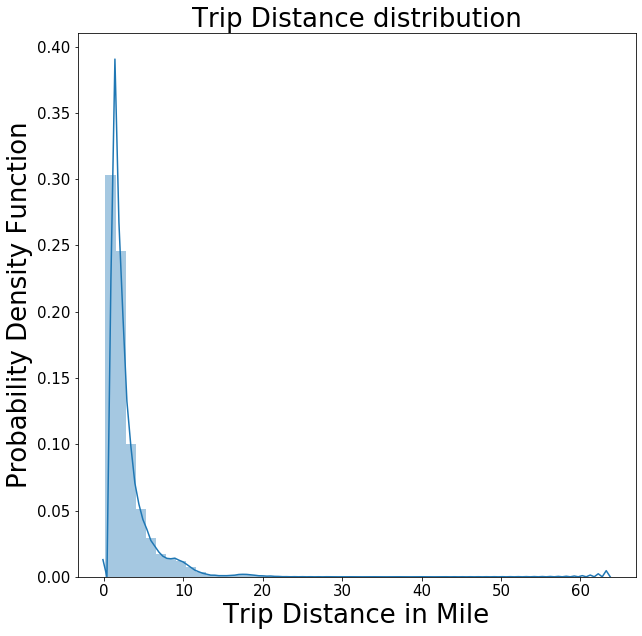

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list['trip_distance'], bins = 50)

ax.set_title(f'Trip Distance distribution', fontsize = 26)
ax.set_xlabel('Trip Distance in Mile', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('8.Trip Distance Distribution.jpg')
plt.close()

In [22]:
tip_percentage = yellow_15_list[yellow_15_list.tip_amount != 0].shape[0] / yellow_15_list.shape[0] *100
print(f'{tip_percentage}% people are willing to tip taxi driver.')

96.22387318800804% people are willing to tip taxi driver.


In [23]:
yellow_15_list = yellow_15_list.drop(yellow_15_list.columns[0], axis=1)

In [24]:
# First column to tip_amount
first_col = yellow_15_list.pop('tip_amount')
yellow_15_list.insert(0, 'tip_amount', first_col)

In [25]:
# Continuous variable -> category
est = KBinsDiscretizer(n_bins = 5, encode='ordinal', strategy='uniform')
est.fit(yellow_15_list.iloc[:,0:1])
label = est.transform(yellow_15_list.iloc[:,0:1])

In [26]:
# boundary value
boundary_value = est.bin_edges_[0].tolist()
boundary_value = list(np.around(np.array(boundary_value),2))

In [27]:
# First column to tip_amount
first_col = yellow_15_list.pop('tip_amount')
yellow_15_list.insert(0, 'tip_amount', label)

# Feature Selection

In [28]:
# drop
yellow_15_list = yellow_15_list.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'vendorid', 
                                     'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude',
                                      'pickup_latitude', 'passenger_count', 'date','month',
                                     'ratecodeid', 'store_and_fwd_flag', 'payment_type', 'price_per_mile',
                                     'price_per_min', 'total_amount', 'except_tip'], axis=1)

In [29]:
# Determine number of attributes
accuracy_list = []
for i in range(3,13):
    x_train, x_test, y_train, y_test = train_test_split(yellow_15_list.iloc[:,1:], yellow_15_list.iloc[:,0], 
                                                        test_size = 0.33, random_state = 40)
    selector = SelectKBest(score_func = chi2, k = i)
    selector.fit(x_train, y_train)
    
    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    x_train = x_train.iloc[:,cols]
    x_test = x_test.iloc[:,cols]

    # Train the model according to the training dataset
    lr_model = LogisticRegression()
    lr_model.fit(x_train, y_train)
    accuracy_list.append(lr_model.score(x_test, y_test))
    print(f'Exact accuracy for Logistic Regression is {lr_model.score(x_test, y_test)}')

Exact accuracy for Logistic Regression is 0.596846863135057
Exact accuracy for Logistic Regression is 0.5935888627734587
Exact accuracy for Logistic Regression is 0.6026468992948834
Exact accuracy for Logistic Regression is 0.6010630988971253
Exact accuracy for Logistic Regression is 0.5983474959320195
Exact accuracy for Logistic Regression is 0.6055758452359429
Exact accuracy for Logistic Regression is 0.6019056228530103
Exact accuracy for Logistic Regression is 0.5998951365033448
Exact accuracy for Logistic Regression is 0.6009329235219671
Exact accuracy for Logistic Regression is 0.6009654673657566


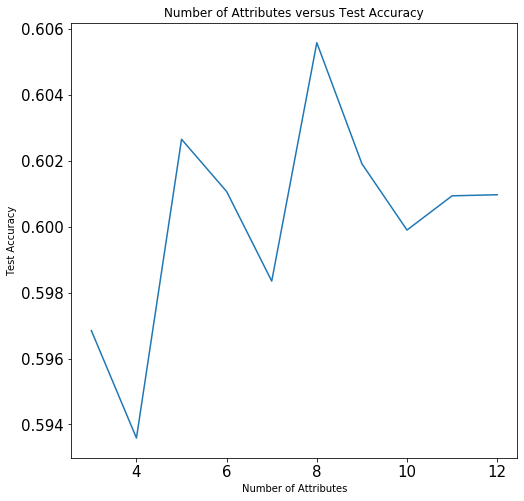

In [30]:
# Accuracy plot
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(3,13), accuracy_list)
plt.title(f'Number of Attributes versus Test Accuracy')
plt.xlabel('Number of Attributes')
plt.ylabel('Test Accuracy')
plt.show()
fig.savefig('9.Number of Attributes versus Test Accuracy.jpg')
plt.close()

In [31]:
x_train, x_test, y_train, y_test = train_test_split(yellow_15_list.iloc[:,1:], yellow_15_list.iloc[:,0], 
                                                    test_size=0.33, random_state = 40)

In [32]:
selector = SelectKBest(score_func = chi2, k = 8)
selector.fit(x_train, y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
x_train_update = x_train.iloc[:,cols]
x_test_update = x_test.iloc[:,cols]

# whole dataframe
plot_dataset = pd.concat([x_train_update, y_train], axis=1)

In [33]:
# Chi2 values
chi2_df = pd.concat([pd.DataFrame({"Column Name": x_train.columns}), 
                     pd.DataFrame({"Chi2" :selector.scores_})], axis=1)
chi2_df.sort_values(by=['Chi2'], ascending=False)

,Column Name,Chi2
1,fare_amount,1.487815e+06
8,duration,1.446200e+06
4,tolls_amount,8.244185e+05
0,trip_distance,7.262461e+05
9,speed,2.285408e+05
6,Temperature,2.877811e+03
11,time,2.749424e+03
2,extra,9.119342e+02
10,dayofweek,3.010370e+02
7,Precipitation,4.913506e+00


In [34]:
# Boundary range
boundary_value_list = []
for i in range(5):
    boundary_value_list.append(f'{boundary_value[i]} - {boundary_value[i+1]}')

In [35]:
# Change 
plot_dataset.loc[plot_dataset['tip_amount'] == 0.0, 'tip_amount'] = boundary_value_list[0]
plot_dataset.loc[plot_dataset['tip_amount'] == 1.0, 'tip_amount'] = boundary_value_list[1]
plot_dataset.loc[plot_dataset['tip_amount'] == 2.0, 'tip_amount'] = boundary_value_list[2]
plot_dataset.loc[plot_dataset['tip_amount'] == 3.0, 'tip_amount'] = boundary_value_list[3]
plot_dataset.loc[plot_dataset['tip_amount'] == 4.0, 'tip_amount'] = boundary_value_list[4]

In [36]:
# Sort the dataframe by target
#fig, ax = plt.subplots(figsize = (10,10))
#sns.distplot(plot_dataset['fare_amount'], hist=False)
#ax.set_title(f'Fare Amount Distribution', fontsize = 26)
#ax.set_xlabel('Fare Amount', fontsize = 26)
#ax.set_ylabel('Probability Density Function', fontsize = 26)
#plt.rc('xtick',labelsize = 20)
#plt.rc('ytick',labelsize = 20)

#fig.savefig('9.Fare Amount Distribution.jpg')
#plt.close()

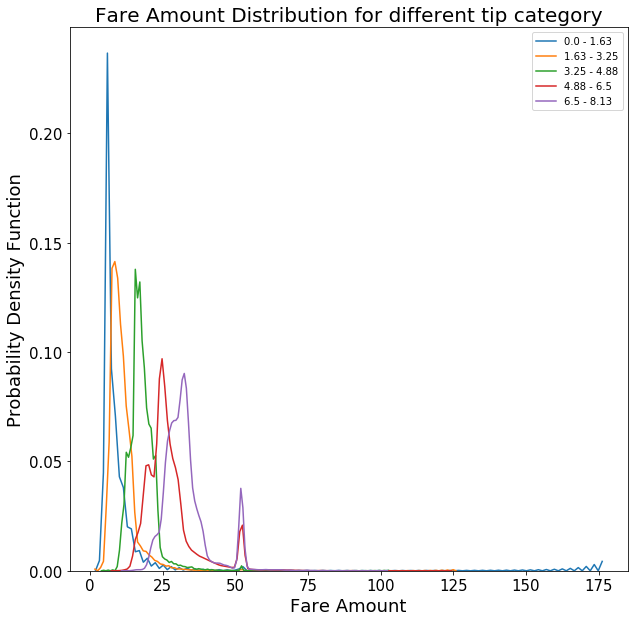

In [37]:
# Sort the dataframe by target
fig, ax = plt.subplots(figsize = (10,10))

target_0 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[0]]
target_1 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[1]]
target_2 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[2]]
target_3 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[3]]
target_4 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[4]]

sns.distplot(target_0[['fare_amount']], hist=False, label = boundary_value_list[0])
sns.distplot(target_1[['fare_amount']], hist=False, label = boundary_value_list[1])
sns.distplot(target_2[['fare_amount']], hist=False, label = boundary_value_list[2])
sns.distplot(target_3[['fare_amount']], hist=False, label = boundary_value_list[3])
sns.distplot(target_4[['fare_amount']], hist=False, label = boundary_value_list[4])

ax.set_title(f'Fare Amount Distribution for different tip category', fontsize = 20)
ax.set_xlabel('Fare Amount', fontsize = 18)
ax.set_ylabel('Probability Density Function', fontsize = 18)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('10.Fare Amount Distribution for different tip category.jpg')
plt.close()

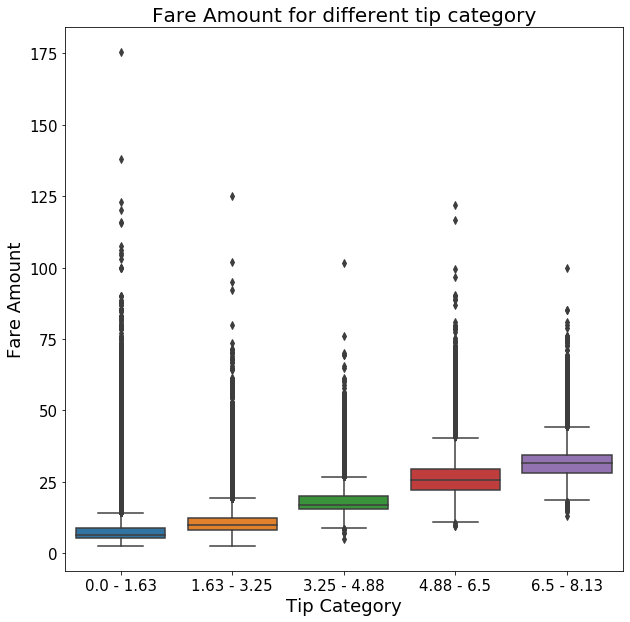

In [38]:
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(x = 'tip_amount', y = 'fare_amount',  data = plot_dataset, 
            order = boundary_value_list)

ax.set_title(f'Fare Amount for different tip category', fontsize = 20)
ax.set_xlabel('Tip Category', fontsize = 18)
ax.set_ylabel('Fare Amount', fontsize = 18)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('11.Fare Amount Boxplot for different tip category.jpg')
plt.close()

In [39]:
duration_summary = pd.DataFrame(plot_dataset.groupby('tip_amount')['fare_amount'].describe())
duration_summary

,count,mean,std,min,25%,50%,75%,max
tip_amount,,,,,,,,
0.0 - 1.63,210197.0,8.181582,5.839767,2.5,5.5,6.5,9.0,175.5
1.63 - 3.25,247292.0,10.912399,4.421818,2.5,8.0,10.0,12.5,125.0
3.25 - 4.88,63024.0,17.834427,4.532469,5.0,15.5,17.0,20.0,101.5
4.88 - 6.5,26643.0,27.207837,8.682019,9.5,22.0,25.5,29.5,122.0
6.5 - 8.13,14322.0,32.783613,7.776344,13.0,28.0,31.5,34.5,100.0


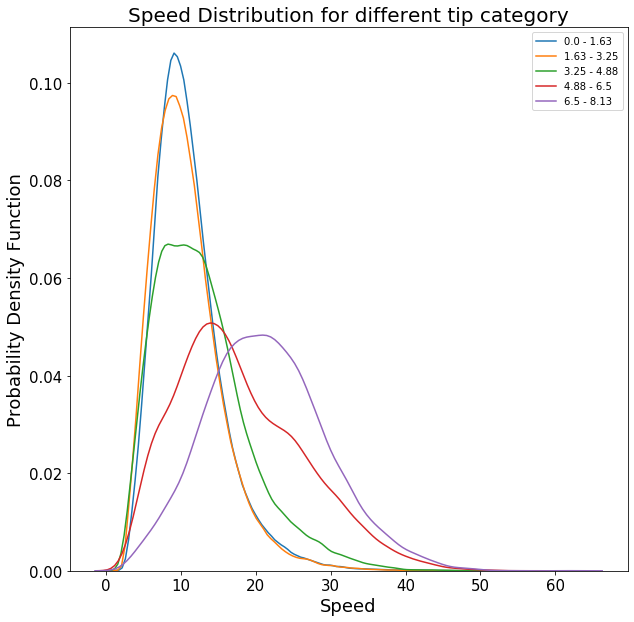

In [40]:
# Sort the dataframe by target
fig, ax = plt.subplots(figsize = (10,10))

target_0 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[0]]
target_1 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[1]]
target_2 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[2]]
target_3 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[3]]
target_4 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[4]]

sns.distplot(target_0[['speed']], hist=False, label = boundary_value_list[0])
sns.distplot(target_1[['speed']], hist=False, label = boundary_value_list[1])
sns.distplot(target_2[['speed']], hist=False, label = boundary_value_list[2])
sns.distplot(target_3[['speed']], hist=False, label = boundary_value_list[3])
sns.distplot(target_4[['speed']], hist=False, label = boundary_value_list[4])

ax.set_title(f'Speed Distribution for different tip category', fontsize = 20)
ax.set_xlabel('Speed', fontsize = 18)
ax.set_ylabel('Probability Density Function', fontsize = 18)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('12.Speed Distribution for different tip category.jpg')
plt.close()

In [41]:
speed_summary = pd.DataFrame(plot_dataset.groupby('tip_amount')['speed'].describe())
speed_summary

,count,mean,std,min,25%,50%,75%,max
tip_amount,,,,,,,,
0.0 - 1.63,210197.0,11.145909,4.714924,0.205491,7.946809,10.344828,13.353116,53.085745
1.63 - 3.25,247292.0,10.800321,4.767407,0.756126,7.453125,10.052313,13.178037,60.274286
3.25 - 4.88,63024.0,12.851321,6.332840,1.121121,8.136986,11.887606,16.160490,50.272189
4.88 - 6.5,26643.0,17.825554,8.516756,2.207625,11.476973,16.444700,23.463438,57.640449
6.5 - 8.13,14322.0,21.382376,7.961265,2.239793,15.751143,20.986559,26.475384,62.540146


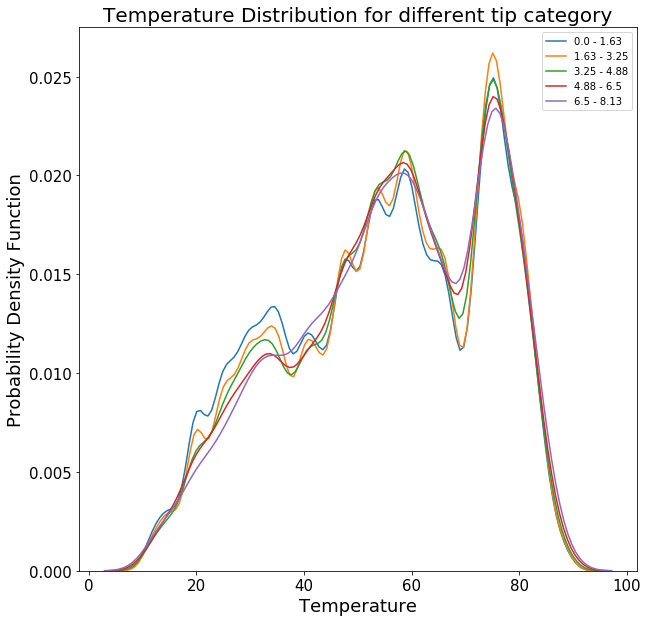

In [42]:
# Sort the dataframe by target
fig, ax = plt.subplots(figsize = (10,10))

target_0 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[0]]
target_1 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[1]]
target_2 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[2]]
target_3 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[3]]
target_4 = plot_dataset.loc[plot_dataset['tip_amount'] == boundary_value_list[4]]

sns.distplot(target_0[['Temperature']], hist=False, label = boundary_value_list[0])
sns.distplot(target_1[['Temperature']], hist=False, label = boundary_value_list[1])
sns.distplot(target_2[['Temperature']], hist=False, label = boundary_value_list[2])
sns.distplot(target_3[['Temperature']], hist=False, label = boundary_value_list[3])
sns.distplot(target_4[['Temperature']], hist=False, label = boundary_value_list[4])

ax.set_title(f'Temperature Distribution for different tip category', fontsize = 20)
ax.set_xlabel('Temperature', fontsize = 18)
ax.set_ylabel('Probability Density Function', fontsize = 18)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('13.Temperature Distribution for different tip category.jpg')
plt.close()

In [43]:
temperature_summary = pd.DataFrame(plot_dataset.groupby('tip_amount')['Temperature'].describe())
temperature_summary

,count,mean,std,min,25%,50%,75%,max
tip_amount,,,,,,,,
0.0 - 1.63,210197.0,54.519515,19.032710,11.5,39.7,56.0,72.1,88.6
1.63 - 3.25,247292.0,55.458562,18.745054,11.5,41.4,57.5,72.6,88.6
3.25 - 4.88,63024.0,55.680282,18.413551,11.5,41.9,57.8,72.3,88.6
4.88 - 6.5,26643.0,55.929880,18.398958,11.5,42.8,58.1,72.6,88.6
6.5 - 8.13,14322.0,56.274473,18.308134,11.5,42.9,58.1,73.1,88.6


In [44]:
#fig, ax = plt.subplots(figsize = (15,15))
#sns.boxplot(x = 'time', y = 'fare_amount', hue = "tip_amount", data = plot_dataset, 
#           hue_order = boundary_value_list)

#ax.set_title(f'Fare Amount for time and tip category', fontsize = 26)
#ax.set_xlabel('Time', fontsize = 26)
#ax.set_ylabel('Fare Amount', fontsize = 26)
#ax.legend(prop = dict(size = 26), loc = 'best')
#plt.rc('xtick',labelsize = 15)
#plt.rc('ytick',labelsize = 15)

#fig.savefig('14.Fare Amount for time and tip category.jpg')
#plt.close()

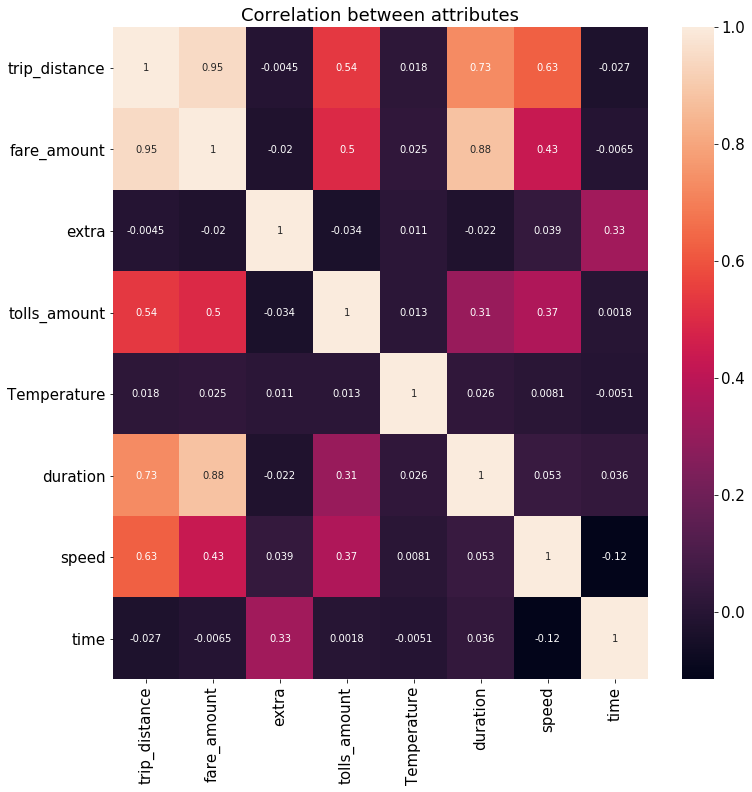

In [45]:
# Correction between selected attributes
fig, ax = plt.subplots(figsize = (12, 12))
corr = x_train_update.corr()
sns.heatmap(corr, annot = True)
plt.title(f'Correlation between attributes', fontsize = 18)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig = plt.gcf()
plt.show()
fig.savefig('14.Correlation between attributes.jpg')
plt.close()

In [46]:
x_train_delete = x_train_update.drop(['trip_distance', 'tolls_amount', 'duration'], axis = 1)
x_test_delete = x_test_update.drop(['trip_distance', 'tolls_amount', 'duration'], axis = 1)

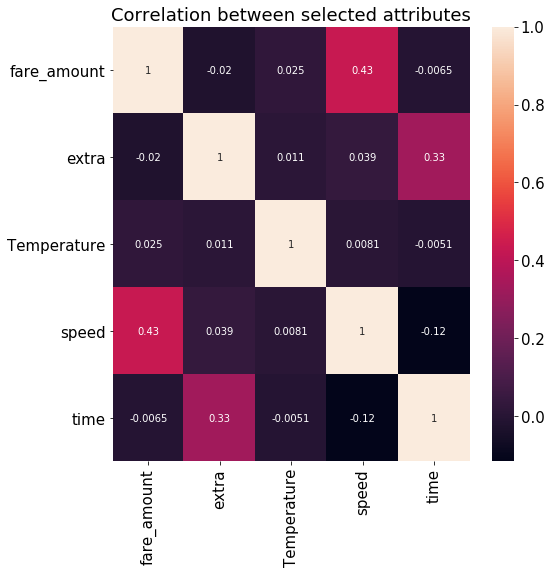

In [47]:
# Correction between selected attributes
fig, ax = plt.subplots(figsize = (8,8))
corr = x_train_delete.corr()
sns.heatmap(corr, annot = True)
plt.title('Correlation between selected attributes', fontsize = 18)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig = plt.gcf()
plt.show()
fig.savefig('15.Correlation between selected attributes.jpg')
plt.close()

# 0-R

In [48]:
# 0-R
dummy_model = DummyClassifier(strategy = "most_frequent")
dummy_model.fit(x_train_update, y_train)
dummy_model.score(x_test_update, y_test)

0.43987344060748507

# Logistic Regression

In [49]:
# Construct the basic model
lr_model = LogisticRegression()

# Train the model according to the training dataset
lr_model.fit(x_train_delete, y_train)

# Predict and analysis the model 
model_pred = lr_model.predict(x_test_delete)
report_analysis = classification_report(y_test, model_pred, target_names = boundary_value_list)
print(report_analysis)
print(f'Exact accuracy for Logistic Regression is {lr_model.score(x_test_delete, y_test)}')

              precision    recall  f1-score   support

  0.0 - 1.63       0.62      0.63      0.62    104049
 1.63 - 3.25       0.54      0.65      0.59    121647
 3.25 - 4.88       0.15      0.07      0.09     30962
  4.88 - 6.5       0.33      0.25      0.29     13011
  6.5 - 8.13       0.24      0.06      0.09      6881

    accuracy                           0.54    276550
   macro avg       0.38      0.33      0.34    276550
weighted avg       0.51      0.54      0.52    276550

Exact accuracy for Logistic Regression is 0.5423648526487073


In [50]:
# Binarize training dataset's label in prepartion of scoring by roc_auc
y_train_binarize = label_binarize(y_train, classes = [0,1,2,3,4])

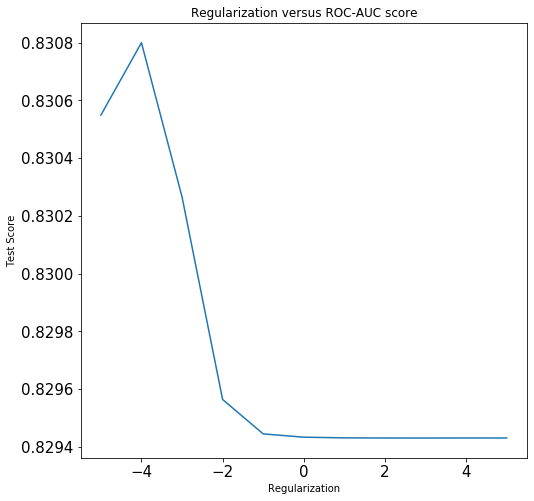

In [51]:
# Cursory search for number of estimators hyperparameter
n_estimators_score = []
for i in np.linspace(-5, 5, 11):
    cv_results = cross_validate(OneVsRestClassifier(LogisticRegression(C = 10**i)), 
                                x_train_delete, y_train_binarize, scoring = 'roc_auc', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
    
# Plot the graph
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(np.linspace(-5, 5, 11), n_estimators_score)
plt.title(f'Regularization versus ROC-AUC score')
plt.xlabel('Regularization')
plt.ylabel('Test Score')
plt.show()
fig.savefig('16.Regularization versus ROC-AUC score.jpg')
plt.close()
# No big difference

In [52]:
# Construct the function that needs to be maximize
# Here the aim is to maximize the roc_auc score
def lr_func(C, solver):
    cv_results = cross_validate(LogisticRegression(C = 10**C, max_iter = 1000, 
                                                solver = ['newton-cg', 'lbfgs', 'saga'][min(int(solver), 2)]),
                            x_train_delete, y_train, scoring = 'accuracy', cv = 5)
    return sum(cv_results['test_score']) / len(cv_results['test_score'])

In [53]:
# Find the global maximum of the target function 
lr_params = BayesianOptimization(lr_func, {'C': (-3,3), 'solver': (0, 3)}, random_state = 42)
lr_params.maximize(n_iter = 20, init_points = 2)

|   iter    |  target   |     C     |  solver   |
-------------------------------------------------
|  1        |  0.5981   | -0.7528   |  2.852    |
|  2        |  0.5983   |  1.392    |  1.796    |
|  3        |  0.5983   | -2.947    |  0.005174 |
|  4        |  0.5982   |  2.998    |  0.1008   |
|  5        |  0.5983   | -2.94     |  2.96     |
|  6        |  0.5982   |  2.899    |  0.0306   |
|  7        |  0.5983   | -2.978    |  2.935    |
|  8        |  0.5981   |  2.954    |  2.826    |
|  9        |  0.5983   | -2.902    |  0.03541  |
|  10       |  0.5982   |  2.872    |  0.03665  |
|  11       |  0.5983   | -2.997    |  2.874    |
|  12       |  0.5981   |  2.976    |  2.965    |
|  13       |  0.5983   | -2.977    |  0.1674   |
|  14       |  0.5981   |  2.984    |  2.594    |
|  15       |  0.5983   | -2.946    |  2.575    |
|  16       |  0.5983   | -2.975    |  0.1856   |
|  17       |  0.5983   | -2.969    |  2.996    |
|  18       |  0.5982   |  2.984    |  0.872    |


In [54]:
# Find the best parameter
final_para_rf = lr_params.max
lr_params.max

{'target': 0.5983119550915704,
 'params': {'C': 1.3919636508684308, 'solver': 1.7959754525911098}}

In [55]:
# For training dataset

# Construct the basic model
lr_model2 = LogisticRegression(C = 10**final_para_rf['params']['C'], max_iter = 1000,
                              solver = ['newton-cg', 'lbfgs','saga'][min(int(final_para_rf['params']['solver']), 2)])

# Train the model according to the training dataset
lr_model2.fit(x_train_delete, y_train)

# Predict and analysis the model 
model_pred = lr_model2.predict(x_train_delete)
report_analysis = classification_report(y_train, model_pred, 
                                        target_names = boundary_value_list)
print(report_analysis)
print(f'Exact accuracy for Logistic Regression is {lr_model2.score(x_train_delete, y_train)}')

              precision    recall  f1-score   support

  0.0 - 1.63       0.68      0.70      0.69    210197
 1.63 - 3.25       0.60      0.69      0.64    247292
 3.25 - 4.88       0.29      0.16      0.21     63024
  4.88 - 6.5       0.31      0.26      0.28     26643
  6.5 - 8.13       0.30      0.10      0.14     14322

    accuracy                           0.60    561478
   macro avg       0.44      0.38      0.39    561478
weighted avg       0.58      0.60      0.58    561478

Exact accuracy for Logistic Regression is 0.5988800985969174


In [56]:
# For testing dataset

# Construct the basic model
lr_model = LogisticRegression(C = 10**final_para_rf['params']['C'], max_iter = 1000, 
                              solver = ['newton-cg', 'lbfgs','saga'][min(int(final_para_rf['params']['solver']), 2)])

# Train the model according to the training dataset
lr_model.fit(x_train_delete, y_train)

# Predict and analysis the model 
model_pred = lr_model.predict(x_test_delete)
report_analysis = classification_report(y_test, model_pred, 
                                        target_names = boundary_value_list)
print(report_analysis)
print(f'Exact accuracy for Logistic Regression is {lr_model.score(x_test_delete, y_test)}')

              precision    recall  f1-score   support

  0.0 - 1.63       0.68      0.69      0.69    104049
 1.63 - 3.25       0.60      0.69      0.64    121647
 3.25 - 4.88       0.28      0.16      0.20     30962
  4.88 - 6.5       0.31      0.26      0.28     13011
  6.5 - 8.13       0.29      0.10      0.14      6881

    accuracy                           0.60    276550
   macro avg       0.43      0.38      0.39    276550
weighted avg       0.57      0.60      0.58    276550

Exact accuracy for Logistic Regression is 0.5981413849213524


In [57]:
# model interception
model_interception = lr_model.intercept_
model_interception = pd.DataFrame(model_interception).transpose()
model_interception.columns = boundary_value_list
model_interception.round(4)

,0.0 - 1.63,1.63 - 3.25,3.25 - 4.88,4.88 - 6.5,6.5 - 8.13
0,5.6822,4.3283,0.1732,-4.046,-6.1377


In [58]:
# model coefficeent
model_coefficient = lr_model.coef_
model_coefficient = pd.DataFrame(model_coefficient)
model_coefficient.columns = x_test_delete.columns
model_coefficient.index = boundary_value_list
model_coefficient.round(4)

,fare_amount,extra,Temperature,speed,time
0.0 - 1.63,-0.3211,-0.521,-0.0016,0.0206,-0.0069
1.63 - 3.25,-0.1385,-0.146,0.0002,-0.0217,-0.0037
3.25 - 4.88,0.0632,0.135,0.0002,-0.0313,-0.0036
4.88 - 6.5,0.1830,0.313,0.0011,0.0022,0.0031
6.5 - 8.13,0.2134,0.219,0.0001,0.0302,0.0111


In [59]:
# model probability 
model_probability = lr_model.predict_proba(x_test_delete)
model_probability = pd.DataFrame(model_probability)
model_probability.columns = boundary_value_list
model_probability.round(5)

,0.0 - 1.63,1.63 - 3.25,3.25 - 4.88,4.88 - 6.5,6.5 - 8.13
0,0.67511,0.30310,0.01911,0.00204,0.00063
1,0.01035,0.18742,0.45403,0.25507,0.09312
2,0.09730,0.45271,0.30859,0.10357,0.03783
3,0.50494,0.45300,0.03860,0.00281,0.00065
4,0.26205,0.60886,0.11313,0.01282,0.00314
...,...,...,...,...,...
276545,0.08677,0.54260,0.30774,0.05002,0.01287
276546,0.36463,0.56264,0.06644,0.00520,0.00109
276547,0.67373,0.30822,0.01659,0.00115,0.00031
276548,0.00000,0.00038,0.04131,0.44859,0.50971


In [60]:
x_beta = np.dot(x_test_delete, lr_model.coef_.T) + lr_model.intercept_
x_beta = pd.DataFrame(x_beta)
x_beta.columns = boundary_value_list
x_beta.round(5)

,0.0 - 1.63,1.63 - 3.25,3.25 - 4.88,4.88 - 6.5,6.5 - 8.13
0,3.42845,2.62765,-0.13596,-2.37241,-3.54773
1,-2.41548,0.48047,1.36529,0.78867,-0.21894
2,-0.36185,1.17557,0.79233,-0.29942,-1.30663
3,2.90521,2.79666,0.33392,-2.28522,-3.75057
4,1.48807,2.33112,0.64804,-1.52958,-2.93765
...,...,...,...,...,...
276545,-0.12798,1.70518,1.13808,-0.67869,-2.03659
276546,2.26697,2.70072,0.56437,-1.98252,-3.54953
276547,3.70749,2.92546,0.00376,-2.66763,-3.96908
276548,-8.52423,-2.60155,2.07601,4.46102,4.58875


In [61]:
prob = softmax(x_beta)
prob = pd.DataFrame(prob)
prob.columns = boundary_value_list
prob.round(5)

,0.0 - 1.63,1.63 - 3.25,3.25 - 4.88,4.88 - 6.5,6.5 - 8.13
0,0.67511,0.30310,0.01911,0.00204,0.00063
1,0.01035,0.18742,0.45403,0.25507,0.09312
2,0.09730,0.45271,0.30859,0.10357,0.03783
3,0.50494,0.45300,0.03860,0.00281,0.00065
4,0.26205,0.60886,0.11313,0.01282,0.00314
...,...,...,...,...,...
276545,0.08677,0.54260,0.30774,0.05002,0.01287
276546,0.36463,0.56264,0.06644,0.00520,0.00109
276547,0.67373,0.30822,0.01659,0.00115,0.00031
276548,0.00000,0.00038,0.04131,0.44859,0.50971


In [62]:
exp_x_beta = pd.DataFrame(np.exp(x_beta))
exp_x_beta['sum'] = np.sum(np.exp(x_beta), axis = 1)
prob = exp_x_beta.iloc[:, 0:5].div(exp_x_beta['sum'], axis=0)
prob = pd.DataFrame(prob)
prob.columns = boundary_value_list
prob.round(5)

,0.0 - 1.63,1.63 - 3.25,3.25 - 4.88,4.88 - 6.5,6.5 - 8.13
0,0.67511,0.30310,0.01911,0.00204,0.00063
1,0.01035,0.18742,0.45403,0.25507,0.09312
2,0.09730,0.45271,0.30859,0.10357,0.03783
3,0.50494,0.45300,0.03860,0.00281,0.00065
4,0.26205,0.60886,0.11313,0.01282,0.00314
...,...,...,...,...,...
276545,0.08677,0.54260,0.30774,0.05002,0.01287
276546,0.36463,0.56264,0.06644,0.00520,0.00109
276547,0.67373,0.30822,0.01659,0.00115,0.00031
276548,0.00000,0.00038,0.04131,0.44859,0.50971


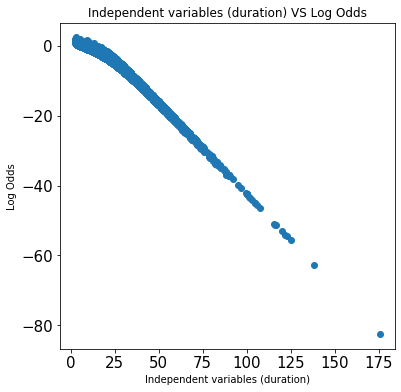

In [63]:
prob_df = pd.DataFrame(lr_model.predict_proba(x_train_delete))
prob_df['1-p'] = 1 - prob_df.iloc[:,0:1]
log_odds = np.log(prob_df.iloc[:,0] / prob_df['1-p'])
# verify linear relationship between independent variables and log odds
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(x_train_delete['fare_amount'], log_odds)
ax.set_title(f'Independent variables (duration) VS Log Odds')
ax.set_xlabel('Independent variables (duration)')
ax.set_ylabel('Log Odds')

plt.rc('xtick',labelsize = 6)
plt.rc('ytick',labelsize = 6)
plt.show()
fig.savefig('17.Independent variables (fare_amount) VS Log Odds.jpg')
plt.close()